Code adapted from https://abhinavcreed13.github.io/blog/bengio-trigram-nplm-using-pytorch/

In [2]:
#load wikitext data

train = []
test = []

train_file_path = '../Srilm//newtraincorpus.txt'
test_file_path = '../Srilm/newtestcorpus.txt'

with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
            # Process each line as a sentence
            words = (line.strip().split())
            train.append(words)

with open(test_file_path, 'r', encoding='utf-8') as file:
    for line in file:
            # Process each line as a sentence
            words = (line.strip().split())
            test.append(words)

print(len(train))
print(len(test))

77363
9418


In [3]:
#split everything into chars

char_train = []
for list in train:
    chars = []
    for string in list:
        for char in string:
            chars.append(char)
    char_train.append(chars)

char_test = []
for list in test:
    chars = []
    for string in list:
        for char in string:
            chars.append(char)
    char_test.append(chars)

train = char_train
test = char_test

In [4]:
train[0]

['v',
 'a',
 'l',
 'k',
 'y',
 'r',
 'i',
 'a',
 'o',
 'f',
 't',
 'h',
 'e',
 'b',
 'a',
 't',
 't',
 'l',
 'e',
 'f',
 'i',
 'e',
 'l',
 'd',
 '<',
 'n',
 'u',
 'm',
 '>',
 'c',
 'o',
 'm',
 'm',
 'o',
 'n',
 'l',
 'y',
 'r',
 'e',
 'f',
 'e',
 'r',
 'r',
 'e',
 'd',
 't',
 'o',
 'a',
 's',
 'v',
 'a',
 'l',
 'k',
 'y',
 'r',
 'i',
 'a',
 'c',
 'h',
 'r',
 'o',
 'n',
 'i',
 'c',
 'l',
 'e',
 's',
 'i',
 'i',
 'i',
 'o',
 'u',
 't',
 's',
 'i',
 'd',
 'e',
 'j',
 'a',
 'p',
 'a',
 'n',
 'i',
 's',
 'a',
 't',
 'a',
 'c',
 't',
 'i',
 'c',
 'a',
 'l',
 'r',
 'o',
 'l',
 'e',
 '@',
 '-',
 '@',
 'p',
 'l',
 'a',
 'y',
 'i',
 'n',
 'g',
 'v',
 'i',
 'd',
 'e',
 'o',
 'g',
 'a',
 'm',
 'e',
 'd',
 'e',
 'v',
 'e',
 'l',
 'o',
 'p',
 'e',
 'd',
 'b',
 'y',
 's',
 'e',
 'g',
 'a',
 'a',
 'n',
 'd',
 'm',
 'e',
 'd',
 'i',
 'a']

In [5]:
#create vocabulary


UNK_symbol = "<UNK>"
vocab = set([UNK_symbol])



# create term frequency of the words
words_term_frequency_train = {}
for doc in train:
    for word in doc:
        # this will calculate term frequency
        # since we are taking all words now
        words_term_frequency_train[word] = words_term_frequency_train.get(word,0) + 1

# create vocabulary
for doc in train:
    for word in doc:
        if words_term_frequency_train.get(word,0) >= 5:
            vocab.add(word)



print(len(vocab))

204


In [6]:
#create 5-grams

import numpy as np
# create required lists
x_train = []
y_train = []

x_test = []
y_test = []


# create word to id mappings
word_to_id_mappings = {}
for idx,word in enumerate(vocab):
    word_to_id_mappings[word] = idx

# function to get id for a given word
# return <UNK> id if not found
def get_id_of_word(word):
    unknown_word_id = word_to_id_mappings['<UNK>']
    return word_to_id_mappings.get(word,unknown_word_id)

# creating training and dev set
for sentence in train:
    for i,word in enumerate(sentence):
        if i+4 >= len(sentence):
            # sentence boundary reached
            break
        # convert word to id
        x_extract = [get_id_of_word(word),get_id_of_word(sentence[i+1]),get_id_of_word(sentence[i+2]), get_id_of_word(sentence[i+3])]
        y_extract = [get_id_of_word(sentence[i+4])]

        x_train.append(x_extract)
        y_train.append(y_extract)

for sentence in test:
    for i,word in enumerate(sentence):
        if i+4 >= len(sentence):
            # sentence boundary reached
            # ignoring sentence less than 3 words
            break
        # convert word to id
        x_extract = [get_id_of_word(word),get_id_of_word(sentence[i+1]),get_id_of_word(sentence[i+2]), get_id_of_word(sentence[i+3])]
        y_extract = [get_id_of_word(sentence[i+4])]

        x_test.append(x_extract)
        y_test.append(y_extract)
  

# making numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)  
  
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7631548, 4)
(7631548, 1)
(884258, 4)
(884258, 1)


In [7]:
#save word to id mapping
import pickle
with open("word2idmaps/5chargram.pkl", 'wb') as f:
    pickle.dump(word_to_id_mappings, f)

In [8]:
# load libraries
import torch
import multiprocessing
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [9]:
# 5gramgram Neural Network Model
class fiveGramNNmodel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(fiveGramNNmodel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size, bias = False)

    def forward(self, inputs):
        # compute x': concatenation of x1 and x2 embeddings
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # compute h: tanh(W_1.x' + b)
        out = torch.tanh(self.linear1(embeds))
        # compute W_2.h
        out = self.linear2(out)
        # compute y: log_softmax(W_2.h)
        log_probs = F.log_softmax(out, dim=1)
        # return log probabilities
        # BATCH_SIZE x len(vocab)
        return log_probs

In [10]:
# create parameters
gpu = 0 
# word vectors size
EMBEDDING_DIM = 50
CONTEXT_SIZE = 4
BATCH_SIZE = 256
# hidden units
H = 200
torch.manual_seed(13013)

# check if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
available_workers = multiprocessing.cpu_count()

print("--- Creating training and dev dataloaders with {} batch size ---".format(BATCH_SIZE))
train_set = np.concatenate((x_train, y_train), axis=1)
test_set = np.concatenate((x_test, y_test), axis=1)
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, num_workers = available_workers)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, num_workers = available_workers)

cuda
--- Creating training and dev dataloaders with 256 batch size ---


In [11]:
# helper function to get accuracy from log probabilities
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc

# helper function to evaluate model on dev data
def evaluate(model, criterion, dataloader, gpu):
    model.eval()

    mean_acc, mean_loss = 0, 0
    count = 0
    losses = []
    with torch.no_grad():
        dev_st = time.time()
        for it, data_tensor in enumerate(dataloader):
            context_tensor = data_tensor[:,0:4].type(torch.LongTensor)
            target_tensor = data_tensor[:,4].type(torch.LongTensor)
            context_tensor, target_tensor = context_tensor.cuda(gpu), target_tensor.cuda(gpu)
            log_probs = model(context_tensor)
            loss = criterion(log_probs, target_tensor)
            mean_loss += loss.item()
            mean_acc += get_accuracy_from_log_probs(log_probs, target_tensor)
            count += 1

                
            if it % 1000 == 0: 
                print("Dev Iteration {} complete. Mean Loss: {}; Mean Acc:{}; Time taken (s): {}".format(it, mean_loss / count, mean_acc / count, (time.time()-dev_st)))
                dev_st = time.time()
                losses.append(loss.item())
    return mean_acc / count, mean_loss / count, losses

import matplotlib.pyplot as plt

def plot_loss(losses, title):
    batches = range(1, len(losses) + 1)
    plt.plot(batches, losses, 'b', label='Training loss')
    plt.title(title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 5.268712520599365; Acc:0.00390625; Time taken (s): 22.16124701499939
Training Iteration 1000 of epoch 0 complete. Loss: 2.2747104167938232; Acc:0.3203125; Time taken (s): 1.2560009956359863
Training Iteration 2000 of epoch 0 complete. Loss: 2.4737870693206787; Acc:0.26953125; Time taken (s): 1.0650007724761963
Training Iteration 3000 of epoch 0 complete. Loss: 1.9726125001907349; Acc:0.4296875; Time taken (s): 1.0680005550384521
Training Iteration 4000 of epoch 0 complete. Loss: 2.0036685466766357; Acc:0.4140625; Time taken (s): 1.065000057220459
Training Iteration 5000 of epoch 0 complete. Loss: 2.2187702655792236; Acc:0.33984375; Time taken (s): 1.0710010528564453
Training Iteration 6000 of epoch 0 complete. Loss: 1.788760781288147; Acc:0.4765625; Time taken (s): 1.0330007076263428
Training Iteration 7000 of epoch 0 complete. Loss: 1.400738000869751; Acc:0.62109375; Time taken (s): 1.0590007305145264
Tra

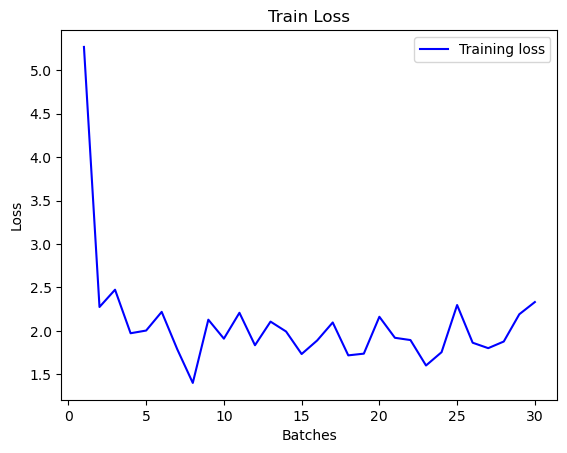

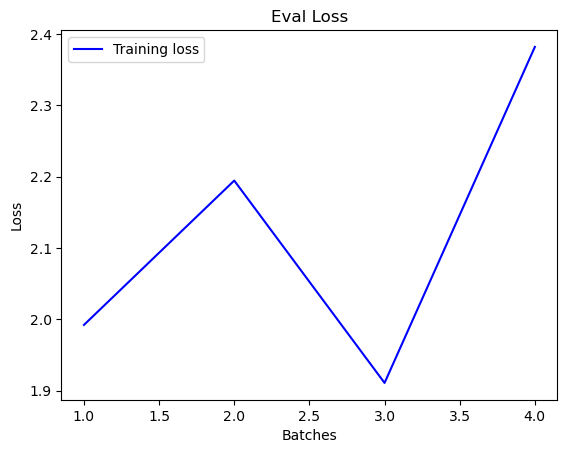

Best development accuracy improved from 0 to 0.395945280790329, saving model...

--- Training model Epoch: 2 ---
Training Iteration 0 of epoch 1 complete. Loss: 1.885619044303894; Acc:0.45703125; Time taken (s): 21.202349424362183
Training Iteration 1000 of epoch 1 complete. Loss: 2.025153875350952; Acc:0.41015625; Time taken (s): 1.3000011444091797
Training Iteration 2000 of epoch 1 complete. Loss: 2.382388114929199; Acc:0.29296875; Time taken (s): 1.083000659942627
Training Iteration 3000 of epoch 1 complete. Loss: 1.8955714702606201; Acc:0.42578125; Time taken (s): 1.0670006275177002
Training Iteration 4000 of epoch 1 complete. Loss: 1.9791096448898315; Acc:0.40625; Time taken (s): 1.0700006484985352
Training Iteration 5000 of epoch 1 complete. Loss: 2.048635721206665; Acc:0.35546875; Time taken (s): 1.0740010738372803
Training Iteration 6000 of epoch 1 complete. Loss: 1.6740028858184814; Acc:0.53125; Time taken (s): 1.0650007724761963
Training Iteration 7000 of epoch 1 complete. Lo

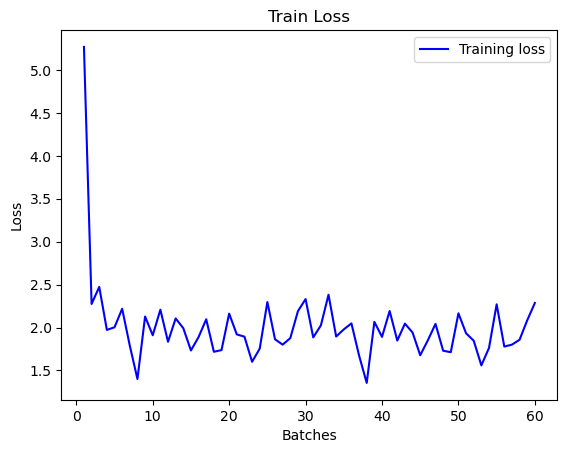

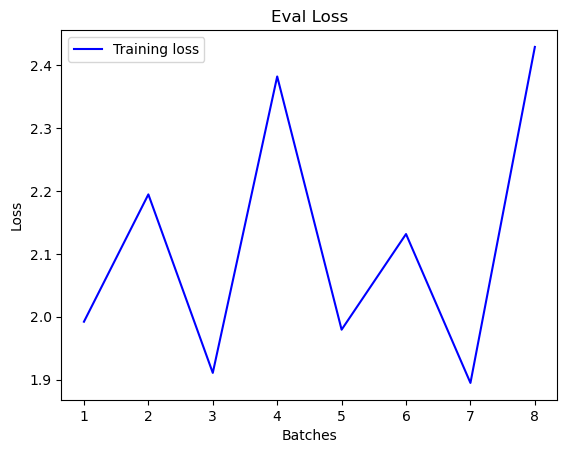

Best development accuracy improved from 0.395945280790329 to 0.40273237228393555, saving model...

--- Training model Epoch: 3 ---
Training Iteration 0 of epoch 2 complete. Loss: 1.8803783655166626; Acc:0.4609375; Time taken (s): 21.406993865966797
Training Iteration 1000 of epoch 2 complete. Loss: 2.010820150375366; Acc:0.421875; Time taken (s): 1.2590014934539795
Training Iteration 2000 of epoch 2 complete. Loss: 2.3065943717956543; Acc:0.3203125; Time taken (s): 1.072000503540039
Training Iteration 3000 of epoch 2 complete. Loss: 1.8734902143478394; Acc:0.4609375; Time taken (s): 1.0750007629394531
Training Iteration 4000 of epoch 2 complete. Loss: 1.9632011651992798; Acc:0.44140625; Time taken (s): 1.0660004615783691
Training Iteration 5000 of epoch 2 complete. Loss: 2.077159881591797; Acc:0.37890625; Time taken (s): 1.0620007514953613
Training Iteration 6000 of epoch 2 complete. Loss: 1.653372883796692; Acc:0.53515625; Time taken (s): 1.0440034866333008
Training Iteration 7000 of 

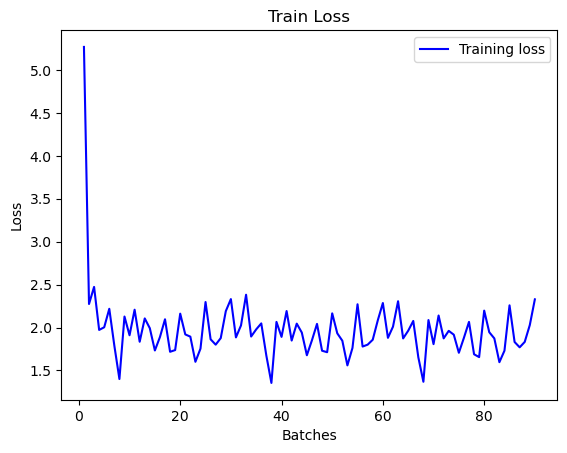

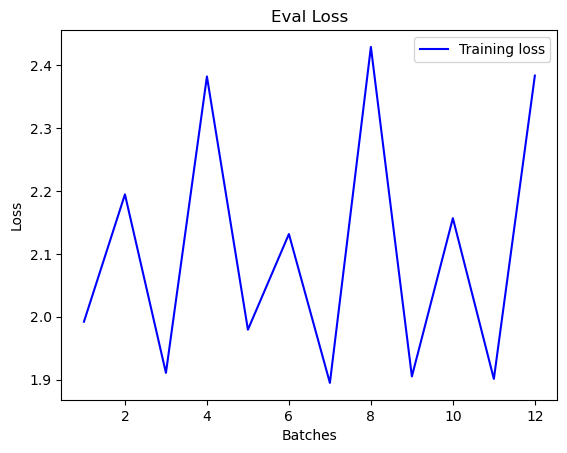

Best development accuracy improved from 0.40273237228393555 to 0.4057098627090454, saving model...

--- Training model Epoch: 4 ---
Training Iteration 0 of epoch 3 complete. Loss: 1.851549744606018; Acc:0.4921875; Time taken (s): 21.112457513809204
Training Iteration 1000 of epoch 3 complete. Loss: 2.018109083175659; Acc:0.41796875; Time taken (s): 1.2270009517669678
Training Iteration 2000 of epoch 3 complete. Loss: 2.285618305206299; Acc:0.34375; Time taken (s): 1.0770008563995361
Training Iteration 3000 of epoch 3 complete. Loss: 1.8907794952392578; Acc:0.453125; Time taken (s): 1.0390009880065918
Training Iteration 4000 of epoch 3 complete. Loss: 1.9827345609664917; Acc:0.42578125; Time taken (s): 1.0180010795593262
Training Iteration 5000 of epoch 3 complete. Loss: 2.112920045852661; Acc:0.3828125; Time taken (s): 1.0350008010864258
Training Iteration 6000 of epoch 3 complete. Loss: 1.6370309591293335; Acc:0.5390625; Time taken (s): 1.037001132965088
Training Iteration 7000 of epo

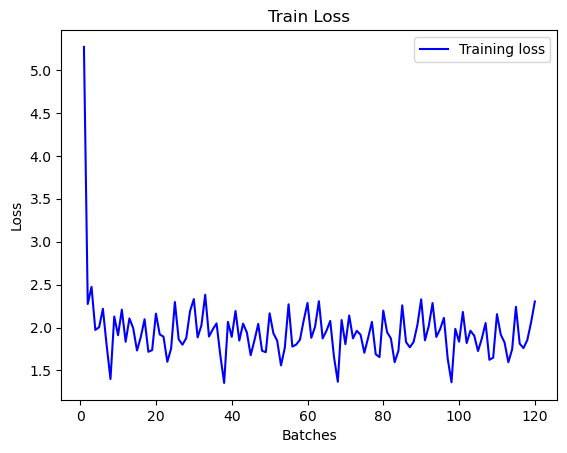

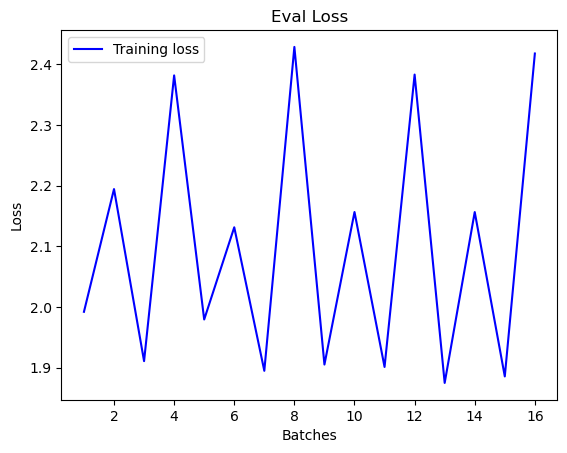

Best development accuracy improved from 0.4057098627090454 to 0.41281574964523315, saving model...

--- Training model Epoch: 5 ---
Training Iteration 0 of epoch 4 complete. Loss: 1.8197238445281982; Acc:0.48046875; Time taken (s): 20.950844049453735
Training Iteration 1000 of epoch 4 complete. Loss: 1.9990298748016357; Acc:0.4140625; Time taken (s): 1.2870054244995117
Training Iteration 2000 of epoch 4 complete. Loss: 2.2816169261932373; Acc:0.328125; Time taken (s): 1.0240001678466797
Training Iteration 3000 of epoch 4 complete. Loss: 1.8393590450286865; Acc:0.45703125; Time taken (s): 1.0380008220672607
Training Iteration 4000 of epoch 4 complete. Loss: 1.9433900117874146; Acc:0.40234375; Time taken (s): 1.0290005207061768
Training Iteration 5000 of epoch 4 complete. Loss: 2.094956159591675; Acc:0.3671875; Time taken (s): 1.0670006275177002
Training Iteration 6000 of epoch 4 complete. Loss: 1.5891228914260864; Acc:0.546875; Time taken (s): 1.0480005741119385
Training Iteration 7000 

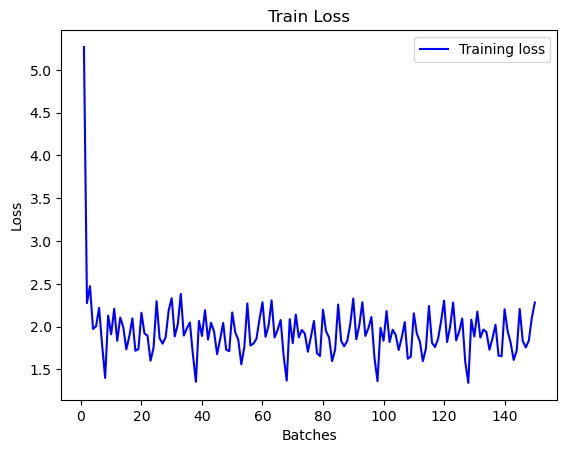

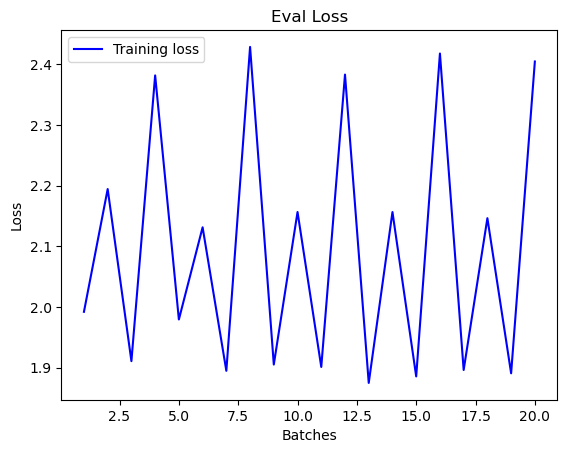


--- Training model Epoch: 6 ---
Training Iteration 0 of epoch 5 complete. Loss: 1.811044692993164; Acc:0.4609375; Time taken (s): 22.970000982284546
Training Iteration 1000 of epoch 5 complete. Loss: 2.0064384937286377; Acc:0.44140625; Time taken (s): 1.5260009765625
Training Iteration 2000 of epoch 5 complete. Loss: 2.286344289779663; Acc:0.359375; Time taken (s): 1.2380011081695557
Training Iteration 3000 of epoch 5 complete. Loss: 1.804437518119812; Acc:0.45703125; Time taken (s): 1.261000633239746
Training Iteration 4000 of epoch 5 complete. Loss: 1.940720558166504; Acc:0.44140625; Time taken (s): 1.2240006923675537
Training Iteration 5000 of epoch 5 complete. Loss: 2.0901477336883545; Acc:0.38671875; Time taken (s): 1.207000494003296
Training Iteration 6000 of epoch 5 complete. Loss: 1.5872952938079834; Acc:0.5625; Time taken (s): 1.2170007228851318
Training Iteration 7000 of epoch 5 complete. Loss: 1.3911828994750977; Acc:0.58203125; Time taken (s): 1.1930007934570312
Training I

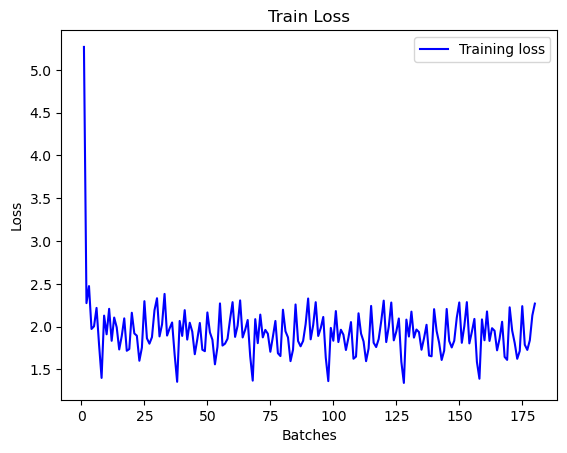

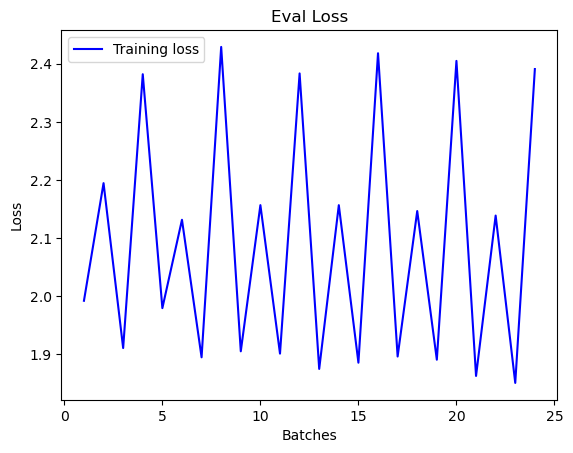


--- Training model Epoch: 7 ---
Training Iteration 0 of epoch 6 complete. Loss: 1.7904057502746582; Acc:0.47265625; Time taken (s): 21.871932983398438
Training Iteration 1000 of epoch 6 complete. Loss: 2.0036487579345703; Acc:0.421875; Time taken (s): 1.4110007286071777
Training Iteration 2000 of epoch 6 complete. Loss: 2.313999652862549; Acc:0.36328125; Time taken (s): 1.2220008373260498
Training Iteration 3000 of epoch 6 complete. Loss: 1.825947880744934; Acc:0.4140625; Time taken (s): 1.1850006580352783
Training Iteration 4000 of epoch 6 complete. Loss: 1.9328036308288574; Acc:0.41015625; Time taken (s): 1.1510004997253418
Training Iteration 5000 of epoch 6 complete. Loss: 2.0914463996887207; Acc:0.390625; Time taken (s): 1.1640007495880127
Training Iteration 6000 of epoch 6 complete. Loss: 1.592603087425232; Acc:0.546875; Time taken (s): 1.1370012760162354
Training Iteration 7000 of epoch 6 complete. Loss: 1.3498601913452148; Acc:0.59375; Time taken (s): 1.1470005512237549
Trainin

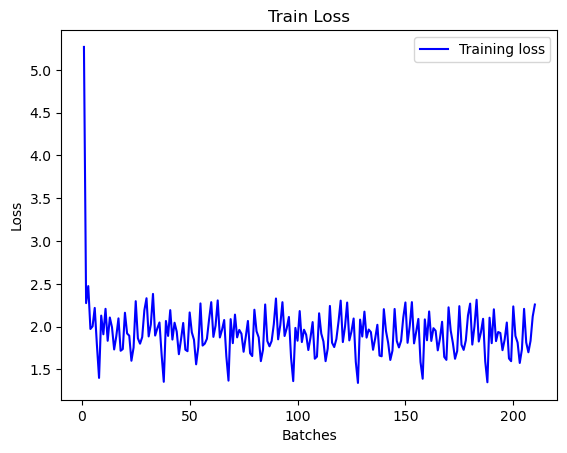

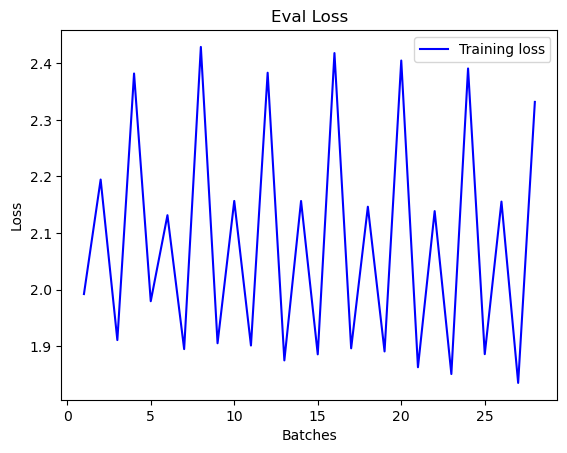


--- Training model Epoch: 8 ---
Training Iteration 0 of epoch 7 complete. Loss: 1.8155889511108398; Acc:0.4765625; Time taken (s): 21.803886890411377
Training Iteration 1000 of epoch 7 complete. Loss: 2.04282808303833; Acc:0.42578125; Time taken (s): 1.3890013694763184
Training Iteration 2000 of epoch 7 complete. Loss: 2.2922635078430176; Acc:0.34765625; Time taken (s): 1.1790008544921875
Training Iteration 3000 of epoch 7 complete. Loss: 1.791042685508728; Acc:0.44921875; Time taken (s): 1.1890008449554443
Training Iteration 4000 of epoch 7 complete. Loss: 1.9006332159042358; Acc:0.42578125; Time taken (s): 1.1990008354187012
Training Iteration 5000 of epoch 7 complete. Loss: 2.0548157691955566; Acc:0.4140625; Time taken (s): 1.1670005321502686
Training Iteration 6000 of epoch 7 complete. Loss: 1.6165356636047363; Acc:0.5546875; Time taken (s): 1.1850013732910156
Training Iteration 7000 of epoch 7 complete. Loss: 1.3367199897766113; Acc:0.59375; Time taken (s): 1.196000337600708
Trai

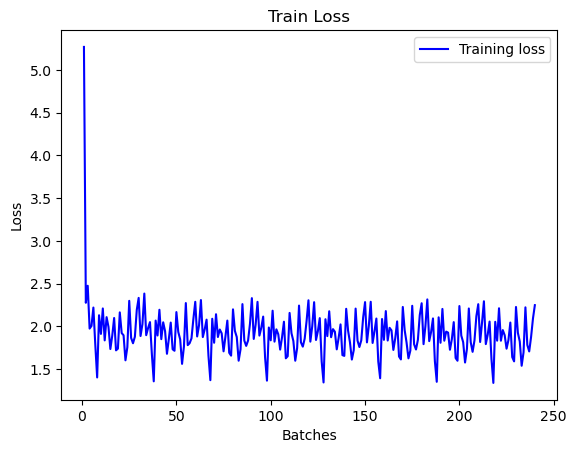

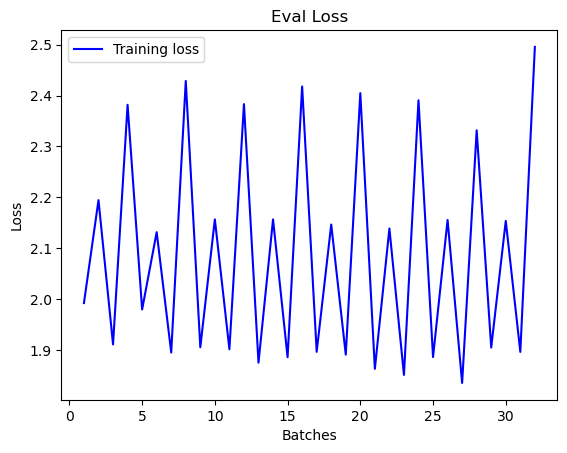

Best development accuracy improved from 0.41281574964523315 to 0.4148558974266052, saving model...


In [12]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
model = fiveGramNNmodel(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE, H)

# load it to gpu
model.cuda(gpu)

# using ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)


# ------------------------- TRAIN & SAVE MODEL ------------------------
best_acc = 0
best_model_path = None
train_losses = []
eval_losses = []
for epoch in range(8):
    st = time.time()
    print("\n--- Training model Epoch: {} ---".format(epoch+1))
    for it, data_tensor in enumerate(train_loader):       
        context_tensor = data_tensor[:,0:4].type(torch.LongTensor)
        target_tensor = data_tensor[:,4].type(torch.LongTensor)

        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # zero out the gradients from the old instance
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy_from_log_probs(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # backward pass and update gradient
        loss.backward()
        optimizer.step()

        if it % 1000 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}".format(it, epoch, loss.item(), acc, (time.time()-st)))
            train_losses.append(loss.item())
            st = time.time()

    print("\n--- Evaluating model on dev data ---")
    dev_acc, dev_loss, e_losses = evaluate(model, loss_function, test_loader, gpu)
    eval_losses = eval_losses + e_losses
    print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}".format(epoch, dev_acc, dev_loss))
    
    plot_loss(train_losses, "Train Loss")
    plot_loss(eval_losses, "Eval Loss")
    
    if dev_acc > best_acc:
        print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
        best_acc = dev_acc
        # set best model path
        best_model_path = 'models/best_char_fivegram_model_{}.dat'.format(epoch)
        # saving best model
        torch.save(model.state_dict(), best_model_path)